Notes penting: ketika kita menggunakan dataset lain untuk melakukan training, pastikan urutannya sama

referensi dataset [link text](https://www.kaggle.com/code/alvinhanafie/sentiment-analysis-for-indonesia-language-with-dnn)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!nvidia-smi

Thu Feb  6 07:56:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!git clone https://github.com/datascienceid/stopwords-bahasa-indonesia

Cloning into 'stopwords-bahasa-indonesia'...
remote: Enumerating objects: 7, done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 7 (from 1)
Receiving objects: 100% (7/7), done.


In [ ]:
!git clone https://github.com/ezaaputra/indonlu.git

Cloning into 'indonlu'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 460 (delta 119), reused 108 (delta 108), pack-reused 312 (from 1)
Receiving objects: 100% (460/460), 4.83 MiB | 11.73 MiB/s, done.
Resolving deltas: 100% (229/229), done.


In [ ]:
!git clone https://github.com/yrtnsari/Sentiment-Analysis-NLP-with-Python

Cloning into 'Sentiment-Analysis-NLP-with-Python'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 22 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 589.49 KiB | 7.28 MiB/s, done.
Resolving deltas: 100% (6/6), done.


# 1. Import Library

In [ ]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt')
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

#Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Exploratory Data Analysis

In [ ]:
df_path = '/content/drive/MyDrive/USH/Project Paper Kolaborasi/Sentiment-Analysis-Using-BERT-main/Dataset/stemming.csv'
stopword_path = '/content/stopwords-bahasa-indonesia/stopwords_id_satya.txt'
kamus_alay_path = '/content/drive/MyDrive/USH/Project Paper Kolaborasi/Sentiment-Analysis-Using-BERT-main/kamus_alay.csv'

In [ ]:
# Import data
# df = pd.read_csv(df_path, sep='\t', header=None, names=['text', 'sentiment', 'tex1', 'stemming'])

In [ ]:
df=pd.read_csv(df_path)
df

,text,sentiment,preprocessing,stemming_ulasan
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,"['warung', 'milik', 'usaha', 'pabrik', 'puluh'...",warung milik usaha pabrik puluh kenal putih ba...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,"['mohon', 'ulama', 'lurus', 'mmbri', 'hujjah',...",mohon ulama lurus mmbri hujjah partai diwlh is...
2,lokasi strategis di jalan sumatera bandung . t...,positive,"['lokasi', 'strategis', 'jalan', 'sumatera', '...",lokasi strategis jalan sumatera bandung nyaman...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,"['betapa', 'bahagia', 'unboxing', 'paket', 'ba...",betapa bahagia unboxing paket barang bagus tet...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,"['aduh', 'mahasiswa', 'sombong', 'kasih', 'kar...",aduh mahasiswa sombong kasih kartu kuning ajar...
...,...,...,...,...
10928,f - demokrat dorong upaya kemandirian energi n...,neutral,"['f', 'demokrat', 'dorong', 'upaya', 'mandiri'...",f demokrat dorong upaya mandiri energi nasional
10929,tidak bosan,positive,['bosan'],bosan
10930,enak rasa masakan nya apalagi kepiting yang me...,positive,"['enak', 'masakan', 'kepiting', 'senang', 'pil...",enak masakan kepiting senang pilih kepiting se...
10931,"pagi pagi di tol pasteur sudah macet parah , b...",negative,"['pagi', 'tol', 'pasteur', 'macet', 'parah', '...",pagi tol pasteur macet parah bikin jengkel


In [ ]:
df = df[['stemming_ulasan', 'sentiment']]

# Remove duplicate rows
df= df.drop_duplicates()
# Filter kalimat yang memiliki lebih dari 15 kata
df = df[df['stemming_ulasan'].apply(lambda x: isinstance(x, str) and len(x.split()) > 5)]
df.shape

(9298, 2)

In [ ]:
df

,stemming_ulasan,sentiment
0,warung milik usaha pabrik puluh kenal putih ba...,positive
1,mohon ulama lurus mmbri hujjah partai diwlh is...,neutral
2,lokasi strategis jalan sumatera bandung nyaman...,positive
3,betapa bahagia unboxing paket barang bagus tet...,positive
4,aduh mahasiswa sombong kasih kartu kuning ajar...,negative
...,...,...
10925,sore pakai baju tebal dingin kurang akses suli...,positive
10928,f demokrat dorong upaya mandiri energi nasional,neutral
10930,enak masakan kepiting senang pilih kepiting se...,positive
10931,pagi tol pasteur macet parah bikin jengkel,negative


In [ ]:
from indonlu.utils.data_utils import DocumentSentimentDataset
df['sentiment'] = df['sentiment'].apply(lambda lab: DocumentSentimentDataset.LABEL2INDEX[lab] if lab in DocumentSentimentDataset.LABEL2INDEX else DocumentSentimentDataset.LABEL2INDEX['neutral'])

In [ ]:
import ast # Import the ast module

# Mengubah string daftar token menjadi list Python dan menggabungkannya kembali menjadi teks
df["Text Filtering"] = df["Text Filtering"].apply(lambda x: " ".join(ast.literal_eval(x)))

In [ ]:
df

,text,sentiment,preprocessing,stemming_ulasan
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,"['warung', 'milik', 'usaha', 'pabrik', 'puluh'...",warung milik usaha pabrik puluh kenal putih ba...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,"['mohon', 'ulama', 'lurus', 'mmbri', 'hujjah',...",mohon ulama lurus mmbri hujjah partai diwlh is...
2,lokasi strategis di jalan sumatera bandung . t...,positive,"['lokasi', 'strategis', 'jalan', 'sumatera', '...",lokasi strategis jalan sumatera bandung nyaman...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,"['betapa', 'bahagia', 'unboxing', 'paket', 'ba...",betapa bahagia unboxing paket barang bagus tet...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,"['aduh', 'mahasiswa', 'sombong', 'kasih', 'kar...",aduh mahasiswa sombong kasih kartu kuning ajar...
...,...,...,...,...
10928,f - demokrat dorong upaya kemandirian energi n...,neutral,"['f', 'demokrat', 'dorong', 'upaya', 'mandiri'...",f demokrat dorong upaya mandiri energi nasional
10929,tidak bosan,positive,['bosan'],bosan
10930,enak rasa masakan nya apalagi kepiting yang me...,positive,"['enak', 'masakan', 'kepiting', 'senang', 'pil...",enak masakan kepiting senang pilih kepiting se...
10931,"pagi pagi di tol pasteur sudah macet parah , b...",negative,"['pagi', 'tol', 'pasteur', 'macet', 'parah', '...",pagi tol pasteur macet parah bikin jengkel


In [ ]:
valid_labels = set(DocumentSentimentDataset.LABEL2INDEX.keys())
df = df[df['sentiment'].isin(valid_labels)]

In [ ]:
df.dtypes

,0
stemming_ulasan,object
sentiment,object


In [ ]:
# Menyimpan hasil ke file baru (opsional)
df.to_csv("dataset_cleaned.tsv", index=False)


In [ ]:
df = pd.read_csv('dataset_cleaned.tsv')

In [ ]:
print(f'shape: {df.shape}')

shape: (100, 2)


## Proporsi Variabel Target

In [ ]:
df['sentiment'] = df['sentiment'].replace({'positive': 'positive', 'negative': 'negative', 'neutral':'neutral'})


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
positive,115
negative,67
neutral,18


In [ ]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%',
           startangle = angle, pctdistance=0.8, explode = explode,
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')
    plt.tight_layout()

In [ ]:
# Plot arguments
sizes = df.sentiment.value_counts()
labels = ['Review Baik', 'Review Netral', 'Review Negatif']
colors = ['lightgreen', 'lightskyblue', 'lightcoral']
explode = (0,0,0)

# sizes = df.sentiment.value_counts()
# labels = ['Review Baik', 'Review Negatif']
# colors = ['lightgreen',  'lightcoral']
# explode = (0,0)

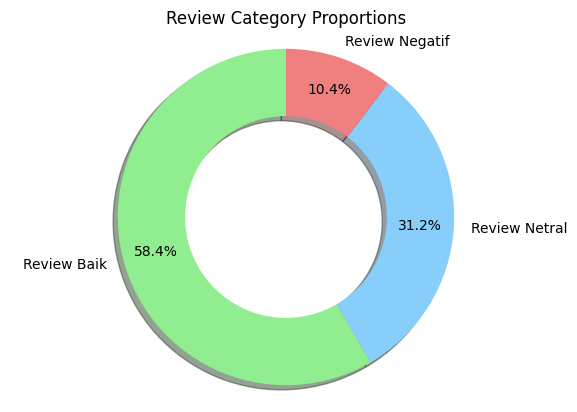

In [ ]:
# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Review Category Proportions')

plt.show()

# 3. PreProcessing

## Preprocessing Tahap 1

In [ ]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(text):
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long
      text = text.replace(char,character[i])
      charac_long -= 1
  return text

In [ ]:
def clean_review(text):
  # ubah text menjadi huruf kecil
  text = text.lower()
  # ubah enter menjadi spasi
  text = re.sub(r'\n', ' ', text)
  # hapus emoji
  text = emoji.demojize(text)
  text = re.sub(':[A-Za-z_-]+:', ' ', text) # delete emoji
  # hapus emoticon
  text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)
  # hapus link
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)
  # hapus usename
  text = re.sub(r"@[^\s]+[\s]?", ' ', text)
  # hapus hashtag
  text = re.sub(r'#(\S+)', r'\1', text)
  # hapus angka dan beberapa simbol
  text = re.sub('[^a-zA-Z,.?!]+',' ',text)
  # hapus karakter berulang
  text = repeatcharClean(text)
  # clear spasi
  text = re.sub('[ ]+',' ',text)
  return text

In [ ]:
def preprocess_v1(df):
  df_pp = df.copy()
  df_pp.review_text = df_pp.text.map(clean_review)

  # delete empty row
  df_pp.text.replace('', np.nan, inplace=True)
  df_pp.text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['text'], inplace=True)
  return df_pp

In [ ]:
df_v1 = preprocess_v1(df)

<ipython-input-116-8e1088d380c9>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_pp.review_text = df_pp.text.map(clean_review)
<ipython-input-116-8e1088d380c9>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pp.text.replace('', np.nan, inplace=True)
<ipython-input-116-8e1088d380c9>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inpla

In [ ]:
# export to tsv
# df_v1.to_csv('df_v1.tsv', sep='\t', header=None, index=False)

## Preprocessing Tahap 2

In [ ]:
# additional_stopword:list kata tdk penting
additional_stop = [] #['ya', 'deh', 'dia']
# default stopword
default_stop = pd.read_csv(stopword_path, names=['stopwords'])
default_stop = default_stop.stopwords.to_list()
# combine all stopword
list_stopwords = []
list_stopwords = default_stop + additional_stop
# remove specific stopword
# list_stopwords.remove("sangat")
# list_stopwords.remove("sekali")

In [ ]:
kamus_alay = pd.read_csv(kamus_alay_path)

normalize_word_dict = {}
for index, row in kamus_alay.iterrows():
    if row[0] not in normalize_word_dict:
        normalize_word_dict[row[0]] = row[1]

<ipython-input-121-b809ff1cd1ac>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalize_word_dict:
<ipython-input-121-b809ff1cd1ac>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalize_word_dict[row[0]] = row[1]


In [ ]:
def normalize_review(text):
  # tokenize
  list_text = word_tokenize(text)
  # ubah bahasa alay
  list_text = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_text]
  # stemming
  # factory = StemmerFactory()
  # stemmer = factory.create_stemmer()
  # list_text = [stemmer.stem(word) for word in list_text]
  # hapus kata yang termasuk stopword
  # list_text = [word for word in list_text if word not in list_stopwords]
  # gabung kembali kalimat
  text = " ".join(list_text)
  return text

In [ ]:
def preprocess_v2(df):
  df_pp = df.copy()
  df_pp.review_text = df_pp.text.map(normalize_review)

  # delete empty row
  df_pp.text.replace('', np.nan, inplace=True)
  df_pp.text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['text'], inplace=True)
  return df_pp

In [ ]:
# take a while
df_v2  = preprocess_v2(df_v1)

<ipython-input-123-f55030b4fbe9>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_pp.review_text = df_pp.text.map(normalize_review)
<ipython-input-123-f55030b4fbe9>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pp.text.replace('', np.nan, inplace=True)
<ipython-input-123-f55030b4fbe9>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an i

In [ ]:
# export to tsv
# df_v2.to_csv('df_v2.tsv', sep='\t', header=None, index=False)

In [ ]:
def make_corpus(column):

    corpus_list = []

    for text in column:
        cleaned_list = text.split(' ')
        corpus_list.extend(cleaned_list)

    # transform list of words into 1 body of text
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+',' ',corpus) # replace double whitespace with one

    return corpus

In [ ]:
# def make_corpus(column):
#     corpus_list = []
#     for text in column:
#         # Check if text is a string before applying split
#         if isinstance(text, str):
#             cleaned_list = text.split(' ')
#             corpus_list.extend(cleaned_list)
#     corpus = ' '.join(corpus_list)
#     corpus = re.sub('[ ]+',' ',corpus)
#     return corpus

In [ ]:
# df['stemming_ulasan'] = df['stemming_ulasan'].fillna('')
corpus = make_corpus(df['text'])

In [ ]:
# counting unique words
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 1137


In [ ]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples

    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})

    return df

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
corpus_freq = word_freq(corpus, top=20)

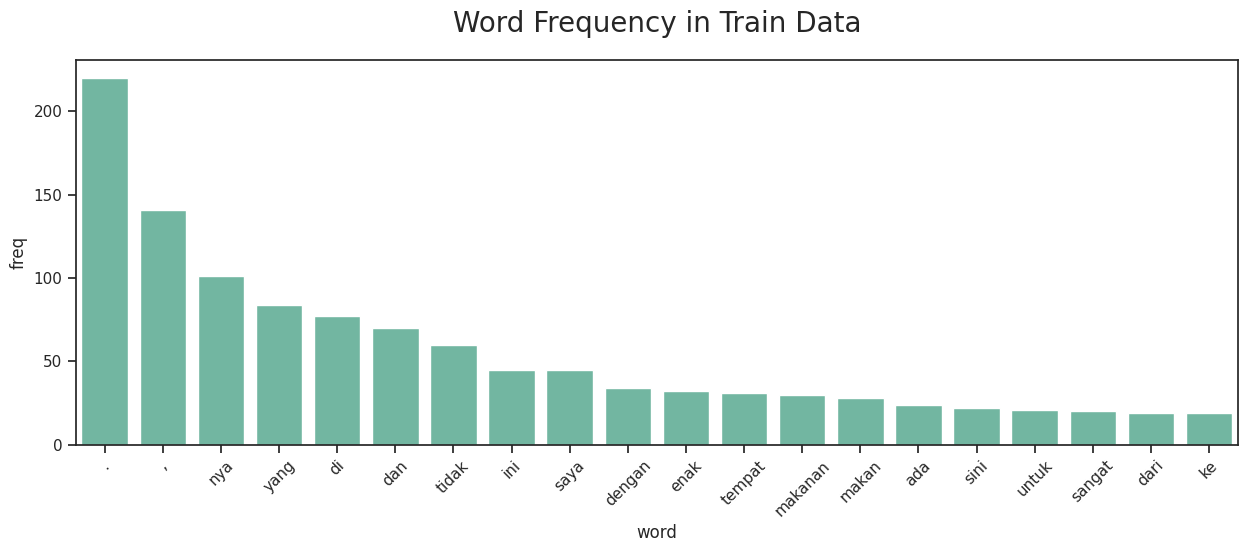

In [ ]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

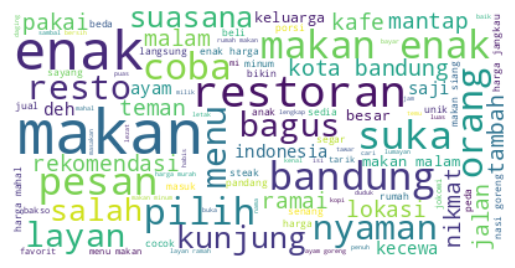

In [ ]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 4. Splitting

In [ ]:
# train val split
train_set, val_set = train_test_split(df, test_size=0.3, stratify=df.sentiment, random_state=1)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.sentiment, random_state=1)

In [ ]:
print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

Train shape: (6508, 2)
Val shape: (1869, 2)
Test shape: (921, 2)


In [ ]:
train_set.dtypes

,0
stemming_ulasan,object
sentiment,object


In [ ]:
# export to tsv
train_set.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('test_set.tsv', sep='\t', header=None, index=False)

In [ ]:
tes = pd.read_csv('test_set.tsv', sep='\t', names=['review_text', 'category'])

In [ ]:
tes

,review_text,category
0,terakhir ke tempat ini beberapa tahun yang lal...,positive
1,berlokasi di salah satu tempat belanja dan rek...,positive
2,makanan tradisional yang selalu rasanya stabil...,positive
3,anak sekarang sulit untuk dinasehati,negative
4,"sehabis puas bermain di trans studio bandung ,...",positive
5,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
6,"tenderloin steak nya juara , tempat mudah diak...",positive
7,bikin macet saja nih orang,negative
8,kuah bakso nya terlalu asin menurut saya . mas...,positive
9,suruh ngaca pemain nya ! dasar oneng ! ngomong...,negative


# 5. Modeling

## a. Finetuning IndoBERT

In [ ]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
# Set random seed
set_seed(27)

## b. Load Model

In [ ]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Struktur model
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
count_param(model)

124443651

## c. Prepare Dataset

In [ ]:
train_dataset_path = '/content/train_set.tsv'
valid_dataset_path = '/content/val_set.tsv'
test_dataset_path = '/content/test_set.tsv'

pastika urutan kolom dataset yang di gunakna sama dengan dataset indonlu

In [ ]:
# fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) #word to index
print(i2w) #index to word

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


## d. Uji coba pre-trained model

In [ ]:
text = 'tidak bisa transfer antar bank'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: tidak bisa transfer antar bank | Label : neutral (55.560%)


In [ ]:
text = 'bisa transfer antar bank?'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bisa transfer antar bank? | Label : neutral (49.986%)


In [ ]:
text = 'bisa transfer antar bank'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bisa transfer antar bank | Label : neutral (48.186%)


## e. Fine Tuning & Prediksi Evaluation

In [ ]:
# Tentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

### Training

In [ ]:
# Train
n_epochs = 5
history = defaultdict(list)
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # save train acc for learning curve
    history['train_acc'].append(metrics['ACC'])

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

    # save validation acc for learning curve
    history['val_acc'].append(metrics['ACC'])

(Epoch 1) TRAIN LOSS:0.4404 LR:0.00000300: 100%|██████████| 204/204 [00:54<00:00,  3.75it/s]


(Epoch 1) TRAIN LOSS:0.4404 ACC:0.84 F1:0.78 REC:0.75 PRE:0.81 LR:0.00000300


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.3657 ACC:0.87 F1:0.82 REC:0.82 PRE:0.83: 100%|██████████| 59/59 [00:08<00:00,  6.94it/s]


(Epoch 1) VALID LOSS:0.3657 ACC:0.87 F1:0.82 REC:0.82 PRE:0.83


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 2) TRAIN LOSS:0.3106 LR:0.00000300: 100%|██████████| 204/204 [00:56<00:00,  3.61it/s]


(Epoch 2) TRAIN LOSS:0.3106 ACC:0.89 F1:0.86 REC:0.85 PRE:0.87 LR:0.00000300


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.3146 ACC:0.89 F1:0.85 REC:0.84 PRE:0.86: 100%|██████████| 59/59 [00:06<00:00,  9.00it/s]


(Epoch 2) VALID LOSS:0.3146 ACC:0.89 F1:0.85 REC:0.84 PRE:0.86


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 3) TRAIN LOSS:0.2555 LR:0.00000300: 100%|██████████| 204/204 [00:54<00:00,  3.71it/s]


(Epoch 3) TRAIN LOSS:0.2555 ACC:0.91 F1:0.89 REC:0.88 PRE:0.90 LR:0.00000300


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.3169 ACC:0.89 F1:0.85 REC:0.87 PRE:0.84: 100%|██████████| 59/59 [00:07<00:00,  8.00it/s]


(Epoch 3) VALID LOSS:0.3169 ACC:0.89 F1:0.85 REC:0.87 PRE:0.84


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 4) TRAIN LOSS:0.2150 LR:0.00000300: 100%|██████████| 204/204 [00:56<00:00,  3.63it/s]


(Epoch 4) TRAIN LOSS:0.2150 ACC:0.93 F1:0.91 REC:0.91 PRE:0.92 LR:0.00000300


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.3277 ACC:0.88 F1:0.83 REC:0.85 PRE:0.83: 100%|██████████| 59/59 [00:08<00:00,  6.90it/s]


(Epoch 4) VALID LOSS:0.3277 ACC:0.88 F1:0.83 REC:0.85 PRE:0.83


  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 5) TRAIN LOSS:0.1771 LR:0.00000300: 100%|██████████| 204/204 [00:56<00:00,  3.64it/s]


(Epoch 5) TRAIN LOSS:0.1771 ACC:0.94 F1:0.93 REC:0.93 PRE:0.94 LR:0.00000300


  0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.3168 ACC:0.89 F1:0.86 REC:0.86 PRE:0.85: 100%|██████████| 59/59 [00:07<00:00,  7.43it/s]

(Epoch 5) VALID LOSS:0.3168 ACC:0.89 F1:0.86 REC:0.86 PRE:0.85


### Learning Curve

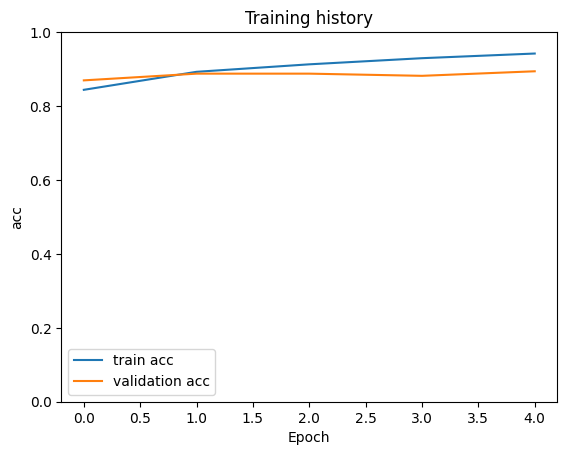

In [ ]:
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Simpan Hasil Prediksi Validation Set
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['review_text', 'category'])
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result.csv', index=False)

## f. Prediksi Test Set

In [ ]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

  0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 29/29 [00:03<00:00,  7.84it/s]


In [ ]:
# Simpan prediksi test set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['review_text', 'category'])
test_df['pred'] = pred
test_df.head()
test_df.to_csv('test result.csv', index=False)

## e. Test fine-tuned model on sample sentences

In [ ]:
text = 'tidak bisa transfer antar bank'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: tidak bisa transfer antar bank | Label : neutral (96.109%)


In [ ]:
text = 'bisa transfer antar bank'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bisa transfer antar bank | Label : neutral (94.964%)


In [ ]:
text = 'bisa transfer antar bank?'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bisa transfer antar bank? | Label : neutral (96.686%)


# 6. Evaluasi

In [ ]:
val_real = val_df.category
val_pred = val_df.pred

test_real = test_df.category
test_pred = test_df.pred

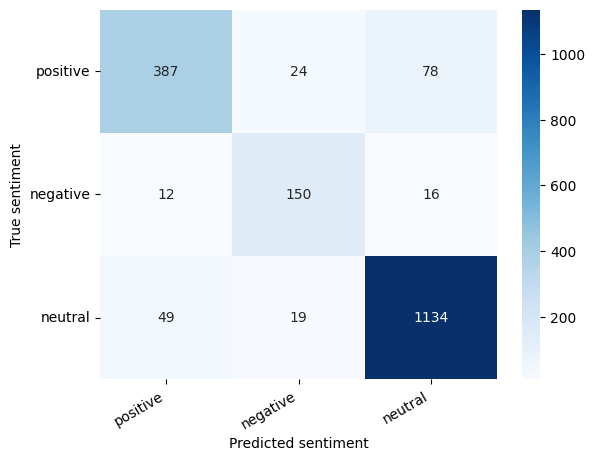

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(val_real, val_pred)
df_cm = pd.DataFrame(cm, index=['positive',  'negative', 'neutral'], columns=['positive',  'negative', 'neutral'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(val_real, val_pred, target_names=['positive', 'negative', 'neutral']))

              precision    recall  f1-score   support

    positive       0.86      0.79      0.83       489
    negative       0.78      0.84      0.81       178
     neutral       0.92      0.94      0.93      1202

    accuracy                           0.89      1869
   macro avg       0.85      0.86      0.86      1869
weighted avg       0.89      0.89      0.89      1869



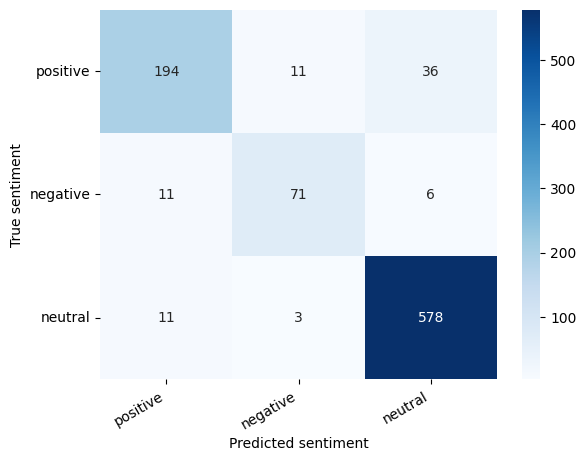

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(test_real, test_pred)
df_cm = pd.DataFrame(cm, index=['positive',  'negative','neutral'], columns=['positive',  'negative','neutral'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(test_real, test_pred, target_names=['positive',  'negative','neutral']))

              precision    recall  f1-score   support

    positive       0.90      0.80      0.85       241
    negative       0.84      0.81      0.82        88
     neutral       0.93      0.98      0.95       592

    accuracy                           0.92       921
   macro avg       0.89      0.86      0.87       921
weighted avg       0.91      0.92      0.91       921

